# 1 线性回归的从零开始实现

In [12]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 根据带有噪声的线性模型构造一个人造数据集。我们使用线性模型参数 $ w = [2, 3.4]^T, b = 4.2$和噪声项$\epsilon$生成数据集及其标签:
$$
y = Xw + b + \epsilon
$$

In [2]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))
    
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

### features 中的每一行都包含一个二维数据样本，labels 中的每一行都包含一维标签值（一个标量）

In [3]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.8852,  0.0701]) 
label: tensor([2.1944])


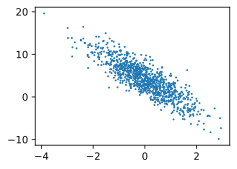

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), 1);

### 定义一个 data_iter 函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为 batch_size 的小批量

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.7920, -1.4446],
        [-0.6952, -1.4977],
        [ 0.9783, -0.6987],
        [ 0.2365, -0.1539],
        [ 2.2735, -0.4658],
        [ 1.1303, -0.3106],
        [ 0.6041, -1.4666],
        [ 0.3654, -0.3961],
        [-1.7204,  0.5061],
        [ 1.7699, -0.6948]]) 
 tensor([[12.6840],
        [ 7.9055],
        [ 8.5229],
        [ 5.1933],
        [10.3108],
        [ 7.5262],
        [10.3871],
        [ 6.2776],
        [-0.9674],
        [10.0918]])


### 定义初始化模型参数

In [6]:
w = torch.normal(0, 0.01, size = (2, 1), requires_grad = True)
b = torch.zeros(1, requires_grad = True)

### 定义模型

In [7]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

###  定义损失

In [8]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 定义优化算法

In [9]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 训练过程

In [10]:
lr = 0.03
num_epochs = 5
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # 'X'和'y'的小批量损失
        # 因为l形状是(batch_size, 1), 而不是一个标量。l中的元素会被加到一起
        # 并以此计算关于[w, b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
        # print(X, '\n', y)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
        

epoch 1, loss 0.036483
epoch 2, loss 0.000141
epoch 3, loss 0.000052
epoch 4, loss 0.000052
epoch 5, loss 0.000052


### 比较真实参数和通过训练学到的参数来评估训练的成功程度

In [11]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'w的估计误差: {true_b - b}')

w的估计误差: tensor([ 3.2282e-04, -4.1246e-05], grad_fn=<SubBackward0>)
w的估计误差: tensor([-0.0008], grad_fn=<RsubBackward1>)
